# CVE Data Review

## Getting Started

### Collecting Data

This cell pulls all JSON files from the NVD that we will be working with.

In [1]:
%%capture
!mkdir -p jsondata
%cd jsondata
!rm *.json 
!rm *.zip 
!wget -q https://nvd.handsonhacking.org/nvd.jsonl

### Import Python Libraries

In [2]:
from IPython.core.magic import register_cell_magic
from IPython.display import Markdown
import datetime
from datetime import date
import glob
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import warnings

@register_cell_magic
def markdown(line, cell):
    return Markdown(cell.format(**globals()))


logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings("ignore")
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)

### Build Base DataFrame

This code builds a Panda dataframe from the JSON files we downloaded, removing all CVE's marked rejected.

In [3]:
row_accumulator = []
for filename in glob.glob('nvd.jsonl'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data:
            cve = entry['cve']['id']
            try:
                assigner = entry['cve']['sourceIdentifier']
            except KeyError:
                assigner = 'Missing_Data'
            try:
                published_date = entry['cve']['published']
            except KeyError:
                published_date = 'Missing_Data'
            try:
                attack_vector = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['attackVector']
            except KeyError:
                attack_vector = 'Missing_Data'
            try:
                attack_complexity = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['attackComplexity']
            except KeyError:
                attack_complexity = 'Missing_Data'
            try:
                privileges_required = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['privilegesRequired']
            except KeyError:
                privileges_required = 'Missing_Data'
            try:
                user_interaction = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['userInteraction']
            except KeyError:
                user_interaction = 'Missing_Data'
            try:
                scope = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['scope']
            except KeyError:
                scope = 'Missing_Data'
            try:
                confidentiality_impact = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['confidentialityImpact']
            except KeyError:
                confidentiality_impact = 'Missing_Data'
            try:
                integrity_impact = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['integrityImpact']
            except KeyError:
                integrity_impact = 'Missing_Data'
            try:
                availability_impact = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['availabilityImpact']
            except KeyError:
                availability_impact = 'Missing_Data'
            try:
                base_score = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['baseScore']
            except KeyError:
                base_score = '0.0'
            try:
                base_severity = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['baseSeverity']
            except KeyError:
                base_severity = 'Missing_Data'
            try:
                exploitability_score = entry['cve']['metrics']['cvssMetricV31'][0]['exploitabilityScore']
            except KeyError:
                exploitability_score = 'Missing_Data'
            try:
                impact_score = entry['cve']['metrics']['cvssMetricV31'][0]['impactScore']
            except KeyError:
                impact_score = 'Missing_Data'
            try:
                cwe = entry['cve']['weaknesses'][0]['description'][0]['value']
            except KeyError:
                cwe = 'Missing_Data'
            try:
                description = entry['cve']['descriptions'][0]['value']
            except IndexError:
                description = ''
            new_row = {
                'CVE': cve,
                'Published': published_date,
                'AttackVector': attack_vector,
                'AttackComplexity': attack_complexity,
                'PrivilegesRequired': privileges_required,
                'UserInteraction': user_interaction,
                'Scope': scope,
                'ConfidentialityImpact': confidentiality_impact,
                'IntegrityImpact': integrity_impact,
                'AvailabilityImpact': availability_impact,
                'BaseScore': base_score,
                'BaseSeverity': base_severity,
                'ExploitabilityScore': exploitability_score,
                'ImpactScore': impact_score,
                'CWE': cwe,
                'Description': description,
                'Assigner' : assigner
            }
            if not description.startswith('rejected reason'): 
                row_accumulator.append(new_row)
        nvd = pd.DataFrame(row_accumulator)
        



nvd['Published'] = pd.to_datetime(nvd['Published'])
nvd = nvd.sort_values(by=['Published'])
nvd = nvd.reset_index(drop=True)
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = nvd['BaseScore'].replace(0, np.NaN);
nvdcount = nvd['Published'].count()
nvd['Published'] = pd.to_datetime(nvd['Published']).apply(lambda x: x.date())
nvdcount = nvd['Published'].count()
startdate = date(2000, 1, 1)
enddate  = date.today()
numberofdays = enddate - startdate 
per_day = nvdcount/numberofdays.days


In [4]:

Markdown(f"Total Number of CVEs: **{nvd['CVE'].count()}**<br />Average CVEs Per Day: **{per_day.round(2)}**<br />Average CVSS Score: **{nvd['BaseScore'].mean().round(2)}**")

Total Number of CVEs: **255511**<br />Average CVEs Per Day: **28.56**<br />Average CVSS Score: **7.1**

### CVEs Graphs

In [5]:
nvd['Published'] = pd.to_datetime(nvd['Published'])
Month_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("M")).agg('count')
Year_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("Y")).agg('count')
Week_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("W")).agg('count')
Day_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("D")).agg('count')

#### Per Year

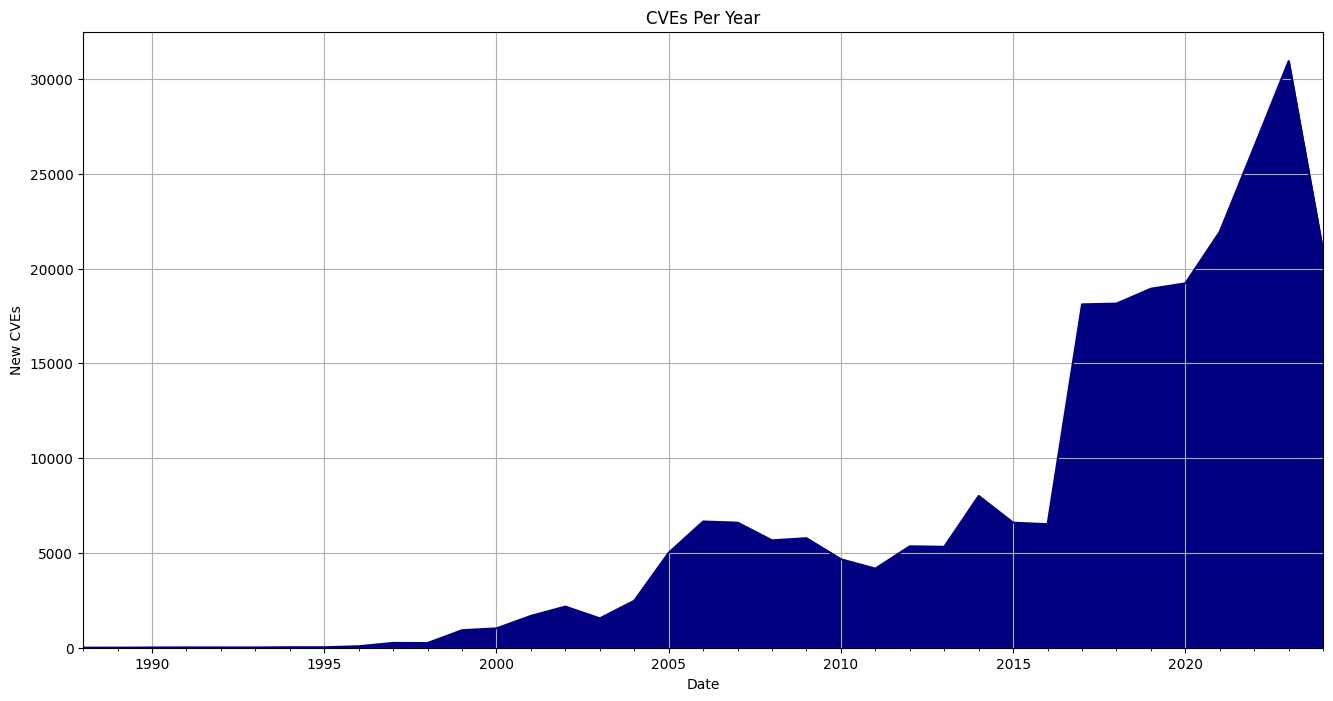

In [6]:
cg = Year_Graph.plot.area(colormap='jet', figsize=(16, 8), title='CVEs Per Year')
plt.grid()
cg.set_ylabel("New CVEs");
cg.set_xlabel("Date");

#### Per Month

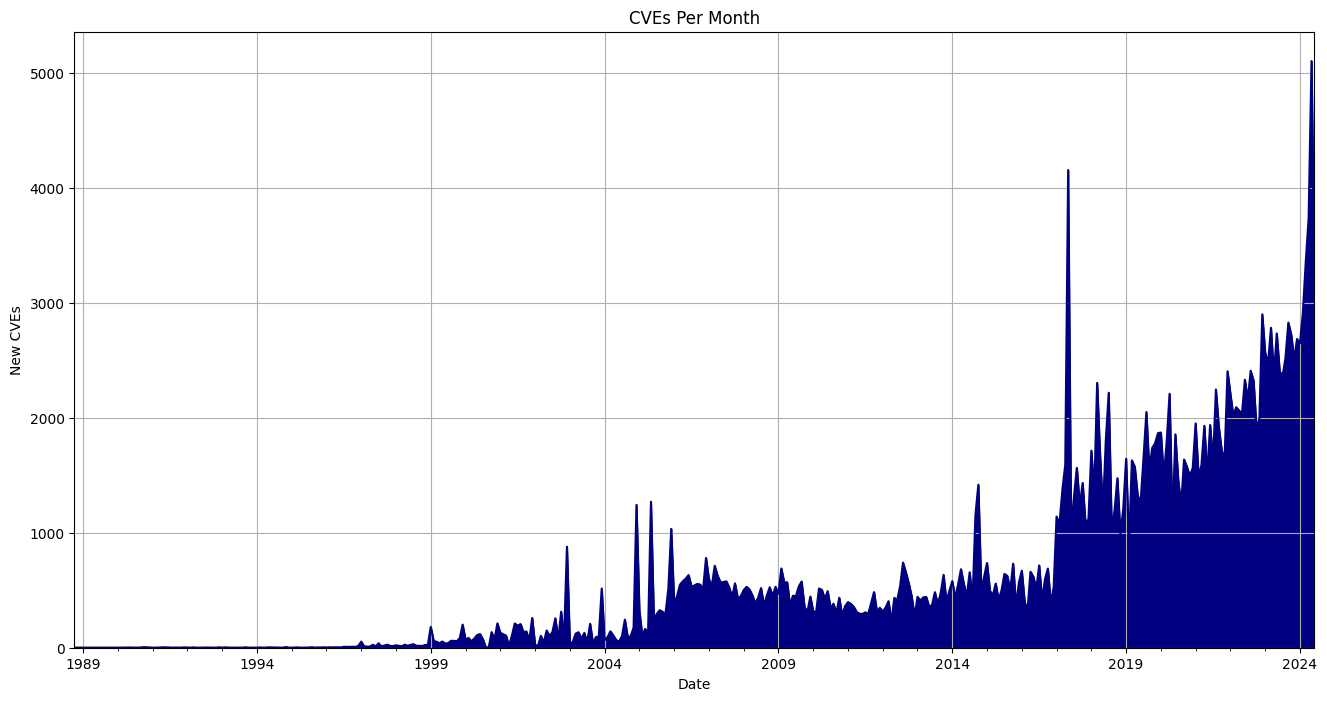

In [7]:
cg = Month_Graph.plot.area(colormap='jet', figsize=(16, 8), title='CVEs Per Month')
plt.grid()
cg.set_ylabel("New CVEs");
cg.set_xlabel("Date");
plt.savefig('All.jpg', dpi=300, bbox_inches='tight')

#### Per Day

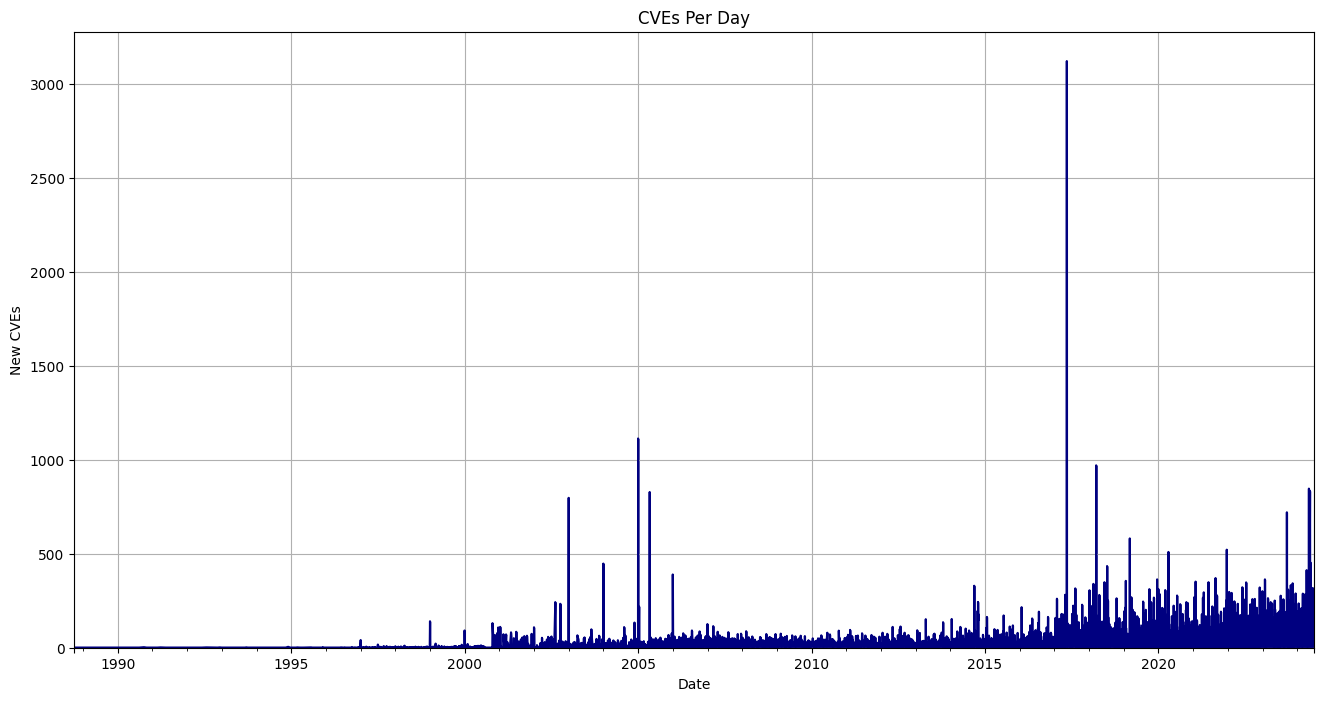

In [8]:
cg = Day_Graph.plot.area(colormap='jet', figsize=(16, 8), title='CVEs Per Day')
plt.grid()
cg.set_ylabel("New CVEs");
cg.set_xlabel("Date");

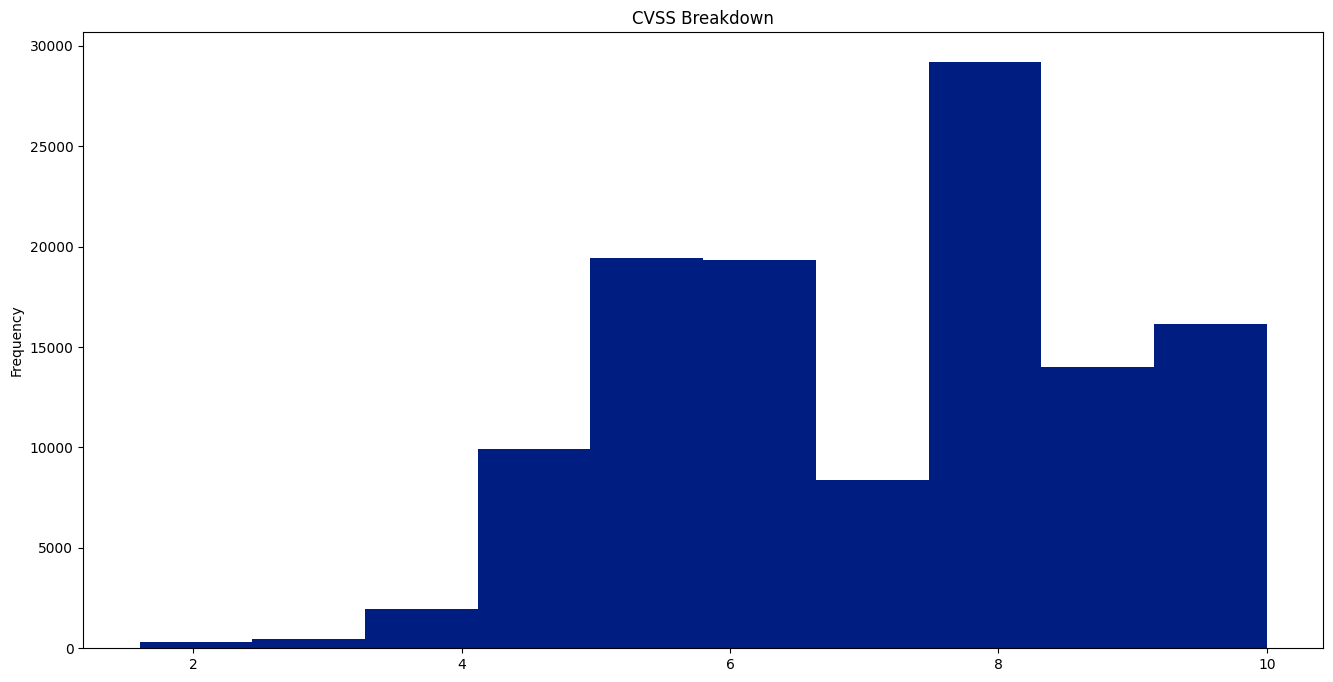

In [9]:
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = nvd['BaseScore'].replace(0, np.NaN);
nvd['BaseScore'].plot(kind="hist", title='CVSS Breakdown', color="#001d82", figsize=(16, 8)); 
plt.savefig('AllCVSS.jpg', dpi=300, bbox_inches='tight',)

In [10]:
Markdown(f"## CNA Data")

## CNA Data

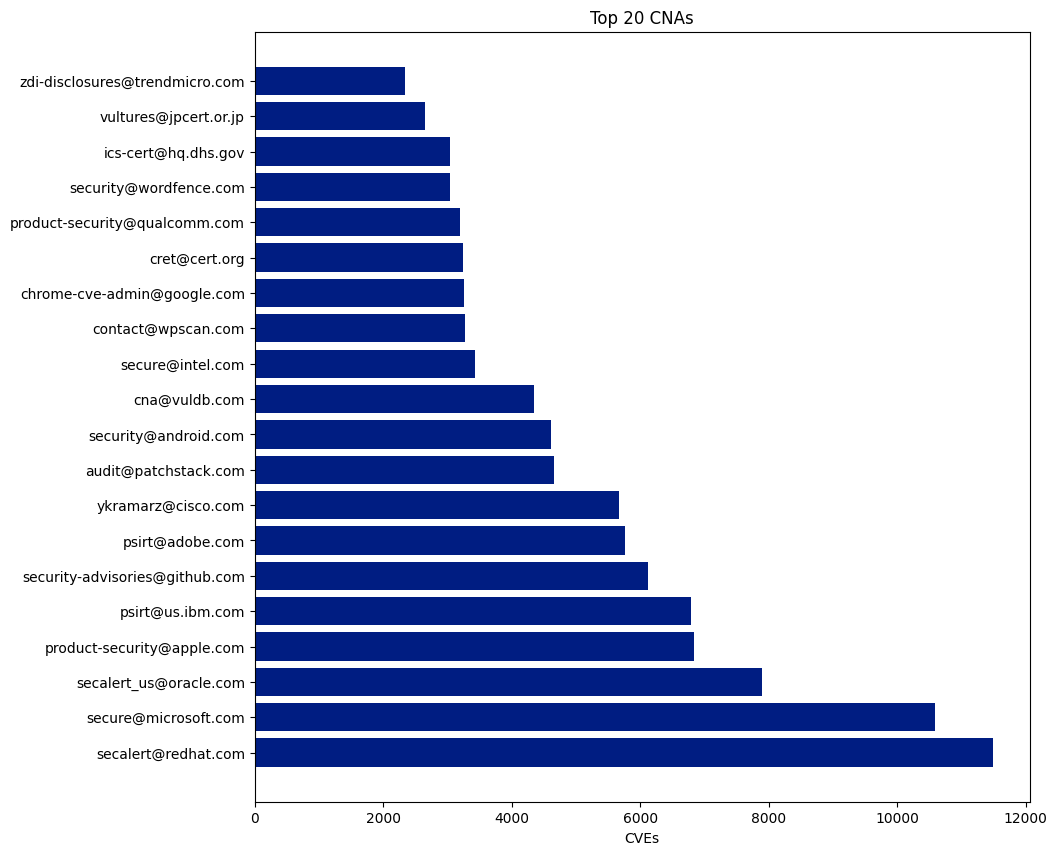

In [11]:
nvd['Assigner'].replace('416baaa9-dc9f-4396-8d5f-8c081fb06d67','cve@kernel.org',inplace=True)
nvd_frequency = nvd['Assigner'].value_counts()
nvd_frequency = nvd_frequency.reset_index()
nvd_frequency.columns = ['Assigner', 'counts']
nvd_frequency[nvd_frequency.counts > 100].head(50)
nvd_frequency_no_mitre = nvd_frequency[~nvd_frequency.Assigner.str.contains('cve@mitre.org')]
nvd_frequency_no_mitre = nvd_frequency_no_mitre[nvd_frequency_no_mitre.counts > 100].head(20)
plt.figure(figsize=(10,10))
plt.barh("Assigner", "counts", data = nvd_frequency_no_mitre, color="#001d82")
plt.xlabel("CVEs"); 
plt.ylabel("") ;
plt.title("Top 20 CNAs");


In [12]:
Markdown(f"## CWE Data")

## CWE Data

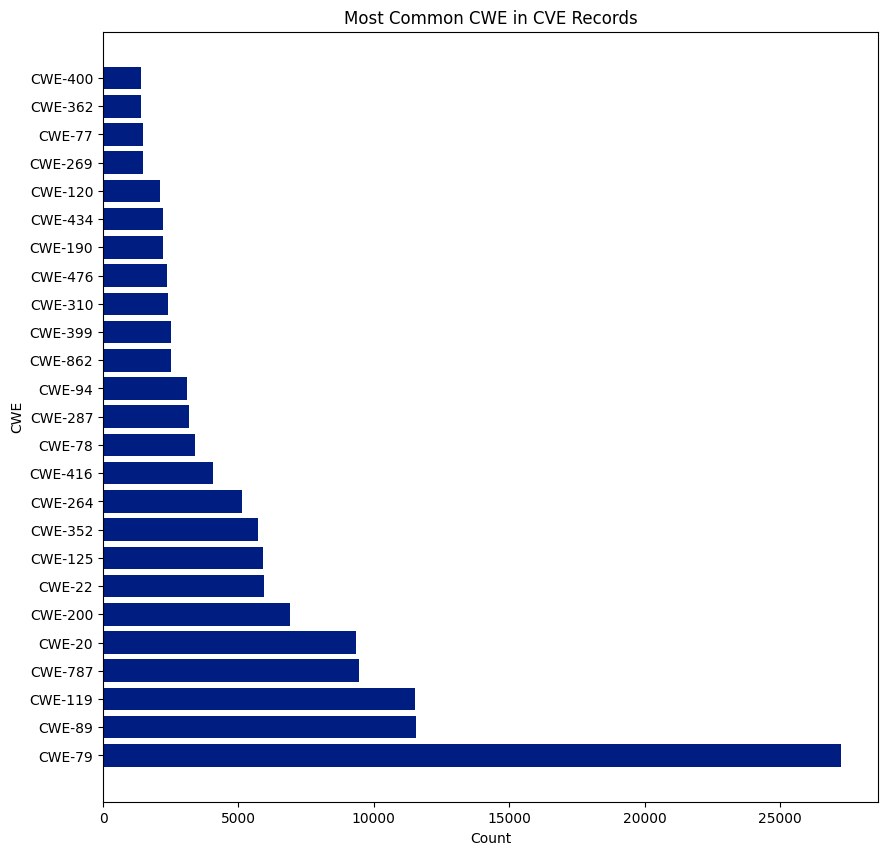

In [13]:
nvd_cwe = nvd['CWE'].value_counts()
nvd_cwe = nvd_cwe.reset_index()
nvd_cwe.columns = ['CWE', 'counts']
nvd_cwe = nvd_cwe[~nvd_cwe.CWE.str.contains('Missing_')]
nvd_cwe = nvd_cwe[~nvd_cwe.CWE.str.contains('NVD')]
nvd_cwe = nvd_cwe[nvd_cwe.counts > 100].head(25)
plt.figure(figsize=(10,10));
plt.barh("CWE", "counts", data = nvd_cwe, color="#001d82");
plt.xlabel("Count"); 
plt.ylabel("CWE") ;
plt.title("Most Common CWE in CVE Records");

In [14]:
Markdown(f"## More CVE Data")

## More CVE Data

In [15]:
Markdown(f"### Top CNA Assigner")

### Top CNA Assigner

In [16]:
nvd_frequency_no_mitre.style.hide_index()

Assigner,counts
secalert@redhat.com,11487
secure@microsoft.com,10583
secalert_us@oracle.com,7894
product-security@apple.com,6832
psirt@us.ibm.com,6793
security-advisories@github.com,6114
psirt@adobe.com,5760
ykramarz@cisco.com,5674
audit@patchstack.com,4656
security@android.com,4608


In [17]:
Markdown(f"### CVEs By Year Published")

### CVEs By Year Published

In [18]:
yg_df = pd.DataFrame(Year_Graph)
yg_df.columns = ['Count']
yg_df.reset_index()
yg_df

,Count
Published,
1988,2
1989,3
1990,11
1991,15
1992,14
1993,13
1994,26
1995,25
1996,75


In [19]:
Markdown(f"### CVEs By Identifier")

### CVEs By Identifier

In [20]:
print("CVE-1999-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-1999-')]))
print("CVE-2000-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2000-')]))
print("CVE-2001-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2001-')]))
print("CVE-2002-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2002-')]))
print("CVE-2003-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2003-')]))
print("CVE-2004-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2004-')]))
print("CVE-2005-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2005-')]))
print("CVE-2006-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2006-')]))
print("CVE-2007-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2007-')]))
print("CVE-2008-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2008-')]))
print("CVE-2009-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2009-')]))
print("CVE-2010-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2010-')]))
print("CVE-2011-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2011-')]))
print("CVE-2012-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2012-')]))
print("CVE-2013-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2013-')]))
print("CVE-2014-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2014-')]))
print("CVE-2015-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2015-')]))
print("CVE-2016-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2016-')]))
print("CVE-2017-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2017-')]))
print("CVE-2018-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2018-')]))
print("CVE-2019-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2019-')]))
print("CVE-2020-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2020-')]))
print("CVE-2021-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2021-')]))
print("CVE-2022-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2022-')]))
print("CVE-2023-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2023-')]))
print("CVE-2024-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2024-')]))

CVE-1999-	1579
CVE-2000-	1242
CVE-2001-	1556
CVE-2002-	2392
CVE-2003-	1553
CVE-2004-	2707
CVE-2005-	4766
CVE-2006-	7142
CVE-2007-	6580
CVE-2008-	7176
CVE-2009-	5040
CVE-2010-	5217
CVE-2011-	4861
CVE-2012-	5892
CVE-2013-	6780
CVE-2014-	8982
CVE-2015-	8747
CVE-2016-	10549
CVE-2017-	16981
CVE-2018-	17352
CVE-2019-	16984
CVE-2020-	20486
CVE-2021-	22875
CVE-2022-	24843
CVE-2023-	28314
CVE-2024-	14915
